In [2]:
"""IMPORTS"""
import numpy as np
from helpers import *
from implementations import *
from utils import *
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [3]:
"""LOADING RAW DATA"""
data_path = 'dataset'
x_tr_raw, x_te_raw, y_tr_raw, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [4]:
"""REMOVE USELESS COLUMNS"""
columns_to_remove = np.concatenate((range(1, 25), range(54, 56)))

x_tr_remove_col = np.delete(x_tr_raw, columns_to_remove, axis=1)
x_te_remove_col = np.delete(x_te_raw, columns_to_remove, axis=1)

"""TREATING SIMILARLY DON'T KNOW, REFUSE AND NAN"""
x_tr_dk = replace_dk_values_with_nan(x_tr_remove_col)
x_te_dk = replace_dk_values_with_nan(x_te_remove_col)

## HYPERPARAMETER SEARCH: DUP

NUMBER OF DUPLICATIONS:  1
Fold:  0
Accuracy: 0.9102503542749173
F1-score: 0.3226770929162834
Fold:  1
Accuracy: 0.9094732351014064
F1-score: 0.31861452001376306
Fold:  2
Accuracy: 0.9120026818230301
F1-score: 0.32574430823117334
Fold:  3
Accuracy: 0.9090922943300775
F1-score: 0.3189497716894977
Fold:  4
Accuracy: 0.9121550581315617
F1-score: 0.32422928144414487
-----------------------------------------
NUMBER OF DUPLICATIONS:  2
Fold:  0
Accuracy: 0.8963231596751338
F1-score: 0.4074203100505138
Fold:  1
Accuracy: 0.8947993965898182
F1-score: 0.39965217391304353
Fold:  2
Accuracy: 0.8975269325125329
F1-score: 0.41013946145075
Fold:  3
Accuracy: 0.8944641687110488
F1-score: 0.39888908175663945
Fold:  4
Accuracy: 0.8961098328431896
F1-score: 0.4028726572079173
-----------------------------------------
NUMBER OF DUPLICATIONS:  3
Fold:  0
Accuracy: 0.876788516921389
F1-score: 0.42814710042432813
Fold:  1
Accuracy: 0.8766513782437106
F1-score: 0.4207513416815742
Fold:  2
Accuracy: 0.8781294

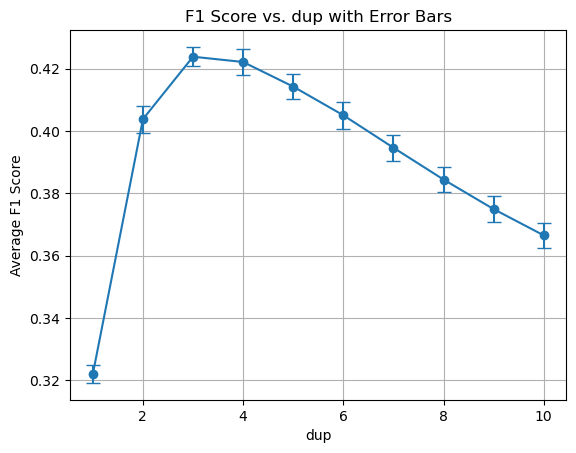

In [4]:
"""HYPERPARAMETER SEARCH: SELECTING BEST NUMBER OF DUPLICATIONS FOR LEAST SQUARES USING CROSS VALIDATION"""
k = 5  # You can choose the number of folds as needed

# Define a list of values for dup to loop through
dup_values = range(1, 11)  # Goes from 0 to 10

# Initialize a list to store average F1 scores for each dup value
average_f1_scores = []
std_dev_f1_scores = []  # List to store standard deviation of F1 scores


for dup in dup_values:
    print("NUMBER OF DUPLICATIONS: ", dup)
    
    np.random.seed(1)
    # Create a KFold cross-validation splitter
    kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

    # Initialize a list to store F1 scores for this dup value
    f1_scores = []

    for i in range(k):
        print("Fold: ", i)
        # Get the indices for the current fold
        val_index = kf[i]
        train_index = np.concatenate([kf[j] for j in range(k) if j != i])

        # Split the data into training and validation sets for this fold
        x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
        y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

        # Nan to mean
        x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

        # Remove columns with one unique value
        x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

        # Standardize
        x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

        # Duplicate
        x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, dup)
        tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

        # Perform least squares regression for this fold
        w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

        # Evaluate the model on the validation set for this fold
        f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

        # Append the MSE score for this fold to the list
        f1_scores.append(f1)

    # Calculate the average F1 score and standard deviation over all folds for this dup value
    average_f1 = np.mean(f1_scores)
    std_dev_f1 = np.std(f1_scores)
    average_f1_scores.append(average_f1)
    std_dev_f1_scores.append(std_dev_f1)
    print("-----------------------------------------")

# Create an error plot with error bars
plt.figure()
plt.errorbar(dup_values, average_f1_scores, yerr=std_dev_f1_scores, marker='o', linestyle='-', capsize=5)
plt.xlabel('dup')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. dup with Error Bars')
plt.grid(True)
plt.show()

## HYPERPARAMETER SEARCH: LAMBDA AND DEGREE

In [7]:
"""SPLITTING TRAINING DATA INTO TRAINING AND VALIDATION"""
x_tr_sp, x_val_sp, y_tr_sp, y_val_sp = split_data(x_tr_dk, y_tr_raw, ratio=0.8, seed=1)

In [3]:
"""HYPERPARAMETER SEARCH: LAMBDA AND DEGREE - ONE VALIDATION SET"""
lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 1e-3, 1e-2,  0.1]
degrees = [1, 2, 3, 4, 5, 6, 7]

f1_best = 0
deg_best = 100
lambda_best = 100

top_10_results = []

x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_sp, x_val_sp)
x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)
x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

for deg in degrees:
    x_poly_tr = build_poly(x_tr_std, deg)
    x_poly_val = build_poly(x_val_std, deg)

    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_poly_tr, y_tr_sp, 3)

    tx = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]
    
    for lambda_ in lambdas:
        print("Degree:", deg, "Lambda:", lambda_)
        
        w_rr, loss = ridge_regression(y_tr_duplicated, tx, lambda_)

        f1 = predict_and_evaluate(x_poly_val, w_rr, y_val_sp, regression_type = "mse")

        result = {
        "Degree": deg,
        "Lambda": lambda_,
        "F1 Score": f1
        }

        if f1 > f1_best:
            f1_best = f1
            deg_best = deg
            lambda_best = lambda_

        top_10_results.append(result)

print("BEST RESULT: ", "lambda: ", lambda_best, "degree: ", deg_best, "f1: ", f1_best)

top_10_results.sort(key=lambda x: x["F1 Score"], reverse=True)

print("Top 10 Results with the Highest F1 Scores:")
for i, result in enumerate(top_10_results[:10]):
    print(f"Rank {i + 1}:")
    print(f"Degree: {result['Degree']}")
    print(f"Lambda: {result['Lambda']}")
    print(f"F1 Score: {result['F1 Score']}")
    print("---------------------------------------------")

In [4]:
"""PLOTTING F1 VS LAMBDA WITH DEGRES DIFFERENTIATION"""

# 'top_10_results' contains the results
lambdas = [result['Lambda'] for result in top_10_results]
f1_scores = [result['F1 Score'] for result in top_10_results]
degrees = [result['Degree'] for result in top_10_results]

# Sort the results by lambda for connected lines
sorted_indices = np.argsort(lambdas)
lambdas = np.array(lambdas)[sorted_indices]
f1_scores = np.array(f1_scores)[sorted_indices]
degrees = np.array(degrees)[sorted_indices]

# Create a semilog plot with lambda on the x-axis and F1 score on the y-axis
plt.figure(figsize=(10, 6))
for degree in set(degrees):
    degree_indices = np.where(degrees == degree)
    plt.semilogx(lambdas[degree_indices], f1_scores[degree_indices], marker='o', label=f'Degree {degree}')

plt.xlabel('Lambda  (Log Scale)')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Lambda (Semilogarithmic Scale) with Degree Differentiation')
plt.grid(True)
plt.legend()
plt.show()

## ABLATION STUDY: BOX PLOT OF MOST RELEVANT STEPS

In [10]:
"""STEP 1: PERFORM LEAST SQUARES ON RAW STANDARDIZED DATA"""

k = 5  # Number of folds (k) for cross-validation

np.random.seed(10)

# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_raw)), k)

# Initialize lists to store results from each fold
f1_step1 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_raw[train_index], x_tr_raw[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step1.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step1)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8633794017706127
F1-score: 0.27377288190507043
Accuracy: 0.9122769591783869
F1-score: 0.2655951014159969
Accuracy: 0.9114693647431698
F1-score: 0.2702838482793268
Accuracy: 0.9106465326770994
F1-score: 0.25978288311032566
Accuracy: 0.9108903347707499
F1-score: 0.2623612512613522
Average F1 score over 5-fold cross-validation: 0.2663591931944144


In [11]:
"""STEP 2: PERFORM LEAST SQUARES AFTER REMOVING IRRELEVANT COLUMNS AND SETTING "DON'T KNOW RESPONSES AND "REFUSED TO ANSWER" TO NAN"""

k = 5  # Number of folds (k) for cross-validation

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step2 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 0)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step2.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step2)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.9087570664513082
F1-score: 0.30934256055363324
Accuracy: 0.9121702957624148
F1-score: 0.3274212368728121
Accuracy: 0.9108598595090436
F1-score: 0.3291284403669725
Accuracy: 0.9095189479939659
F1-score: 0.3141603141603142
Accuracy: 0.9114846023740228
F1-score: 0.32898232644103037
Average F1 score over 5-fold cross-validation: 0.32180697567895244


In [13]:
"""STEP 3: PERFORM LEAST SQUARES AFTER OPTIMIZING THE NUMBER OF DUPLICATIONS (DUP = 3)"""

k = 5  # Number of folds (k) for cross-validation

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step3 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 3)
    tx_tr = np.c_[np.ones((x_tr_duplicated.shape[0], 1)), x_tr_duplicated]

    # Perform least squares regression for this fold
    w_LS, mse_LS = least_squares(y_tr_duplicated, tx_tr)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_val_std, w_LS, y_val_fold)

    # Append the MSE score for this fold to the list
    f1_step3.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step3)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8747771496487726
F1-score: 0.41741103076704944
Accuracy: 0.877672299510872
F1-score: 0.42302716688227693
Accuracy: 0.8774589726789279
F1-score: 0.42851051733939743
Accuracy: 0.8772913587395432
F1-score: 0.42482679808585105
Accuracy: 0.8765142395660322
F1-score: 0.42654967449759407
Average F1 score over 5-fold cross-validation: 0.42406503751443375


In [14]:
"""STEP 4: POLYNOMIAL RIDGE REGRESSION"""

k = 5  # Number of folds (k) for cross-validation

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

dup = 3
lambda_ = 0.00028
degree = 5

np.random.seed(10)
# Create a KFold cross-validation splitter
kf = np.array_split(np.random.permutation(len(x_tr_dk)), k)

# Initialize lists to store results from each fold
f1_step4 = []

for i in range(k):
    # Get the indices for the current fold
    val_index = kf[i]
    train_index = np.concatenate([kf[j] for j in range(k) if j != i])

    # Split the data into training and validation sets for this fold
    x_tr_fold, x_val_fold = x_tr_dk[train_index], x_tr_dk[val_index]
    y_tr_fold, y_val_fold = y_tr_raw[train_index], y_tr_raw[val_index]

    # The rest of your cross-validation code remains the same...

    # Nan to mean
    x_tr_no_nan, x_val_no_nan = nan_to_mean(x_tr_fold, x_val_fold)

    # Remove columns with one unique value
    x_tr_no_unique, x_val_no_unique = remove_uniquevalue_cols(x_tr_no_nan, x_val_no_nan)

    # Standardize
    x_tr_std, x_val_std = standardize(x_tr_no_unique, x_val_no_unique)

    # Duplicate
    x_tr_duplicated, y_tr_duplicated = duplicate_1rows(x_tr_std, y_tr_fold, 3)
    x_poly_tr = build_poly(x_tr_duplicated, degree)
    x_poly_val = build_poly(x_val_std, degree)

    tx_tr = np.c_[np.ones((x_poly_tr.shape[0], 1)), x_poly_tr]

    # Perform least squares regression for this fold
    w_LS, mse_LS = ridge_regression(y_tr_duplicated, tx_tr, lambda_)

    # Evaluate the model on the validation set for this fold
    f1 = predict_and_evaluate(x_poly_val, w_LS, y_val_fold)
    
    # Append the MSE score for this fold to the list
    f1_step4.append(f1)

# Calculate the average MSE over all folds
average_f1 = np.mean(f1_step4)

print(f'Average F1 score over {k}-fold cross-validation: {average_f1}')


Accuracy: 0.8788760723482713
F1-score: 0.4340334638661445
Accuracy: 0.8816645587943986
F1-score: 0.4392779783393502
Accuracy: 0.8812379051305103
F1-score: 0.43871525277257667
Accuracy: 0.8809331525134472
F1-score: 0.4369505692462891
Accuracy: 0.8802169838633489
F1-score: 0.43773692868893505
Average F1 score over 5-fold cross-validation: 0.4373428385826591


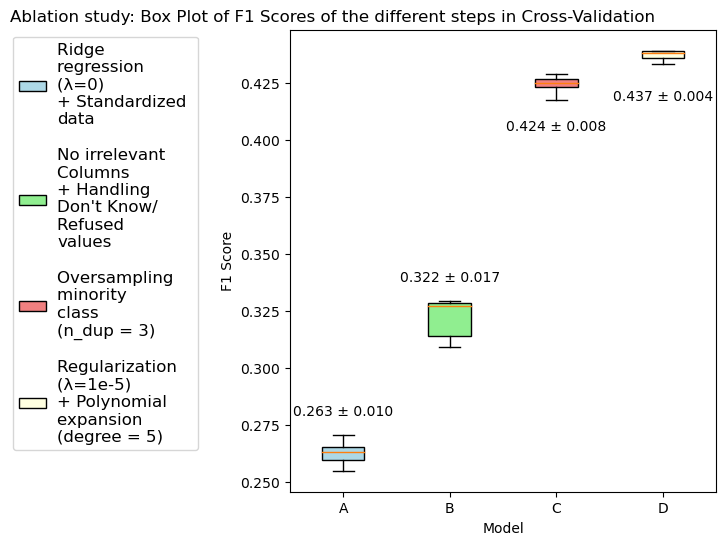

In [6]:
"""PLOTTING THE BOX PLOTS"""

# Create a box plot of the F1 scores
plt.figure(figsize=(5.5, 6))  # Increased the figure width

# Create boxplots for each step
box1 = plt.boxplot(f1_step1, positions=[1], notch=False, patch_artist=True, widths=0.4, whis=2)  # Set whis to 2
box2 = plt.boxplot(f1_step2, positions=[2], notch=False, patch_artist=True, widths=0.4, whis=2)
box3 = plt.boxplot(f1_step3, positions=[3], notch=False, patch_artist=True, widths=0.4, whis=2)
box5 = plt.boxplot(f1_step4, positions=[4], notch=False, patch_artist=True, widths=0.4, whis=2)

# Set colors for the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow']
for box, color in zip([box1, box2, box3, box5], colors):
    for patch in box['boxes']:
        patch.set_facecolor(color)

tit = plt.title('Ablation study: Box Plot of F1 Scores of the different steps in Cross-Validation')
tit.set_position((0.1,0))
plt.xlabel('Model')
plt.ylabel('F1 Score')

# Calculate and add the mean values to the box plots
mean_values = [np.mean(f1_step1), np.mean(f1_step2), np.mean(f1_step3), np.mean(f1_step4)]
std_values = [np.std(f1_step1), np.std(f1_step2), np.std(f1_step3), np.std(f1_step4)]

for i, (mean, std) in enumerate(zip(mean_values, std_values)):
    if i < 2:
        plt.text(i + 1, mean + 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='bottom', fontsize=10)
    else:
        plt.text(i + 1, mean - 0.015, f"{mean:.3f} ± {2*std:.3f}", ha='center', va='top', fontsize=10)

# Create a custom legend
legend_boxes = [box1["boxes"][0], box2["boxes"][0], box3["boxes"][0], box5["boxes"][0]]
legend = plt.legend(legend_boxes, ['Ridge \nregression \n(λ=0) \n+ Standardized \ndata', 'No irrelevant \nColumns \n+ Handling \nDon\'t Know/\nRefused \nvalues', 'Oversampling \nminority \nclass \n(n_dup = 3)', 'Regularization \n(λ=1e-5) \n+ Polynomial \nexpansion \n(degree = 5)'],\
            loc='upper right', bbox_to_anchor=(-0.2, 1), labelspacing = 1.5)
legend.get_texts()[0].set_fontsize(12)
legend.get_texts()[1].set_fontsize(12)
legend.get_texts()[2].set_fontsize(12)
legend.get_texts()[3].set_fontsize(12)


# Set the x-axis ticks and labels
plt.xticks([1, 2, 3, 4], ['A', 'B', 'C', 'D'])

plt.show()